# Simulating the movement of monomers and polymers

### Introduction

In this numerical project we will look at the movement of membrane-free organelles found in the nucleoli of a cell. The nucleoli consist of electric charged monomers that move around and form polymers due to the electromagnetnic forces. To simulate this movement we use the Monte Carlo method, which utilize random sampling along some pre stated conditions over millions of steps to mimmic the conditions found in the nucleoli. We assume that all movement occurs because of electromagnetic forces or because of variations in thermal energy. Therefore we run the simulations at different temperatures and initial conditions.

From the simulation we can extract interesting values like expected value of the size of the polymers. (We will use the mean value to estimate this). And the development of the energy in the system. 

The montecarlo methods used in the exercise involve large scale calculations. We use jit from the numba library, which translates functions to optimized machine code. This drastically lowers runtime. Every function that is iterated over in a MC function will be jitted.

The project is structured like this: We do the tasks in order with explanations as paragraphs above the code. The code is also filled with comments explaining the steps taken. 

In [2]:
#importing libraries and numba
import numpy as np
import random as rdm
import matplotlib.pyplot as plt
from matplotlib import colors

%pip install numba
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from time import time




Note: you may need to restart the kernel to use updated packages.


## Monomers

1a) We start by looking at systems of monomers placed in a solvent. Monomers have electrical charge of e or -e. Opposite charged monomers attract each other and can form crystal-like structures as we will later see. First of all we have to construct the functions that we need to portray more complex systems.

First we generate a random grid of monomers, and assign each monomer a value from -m to m (not 0). Each monomer has a unique value to make it easier to solve problems later on. Their charge is given by their sign. The function inputs n and m and returns an n x n array with 2m monomers.

In [3]:

@jit(nopython=True)
def generate_grid_of_monomers(n,m):
    grid = np.zeros((n,n),dtype=np.dtype('i2')) # creating grid
    
    # fills the grid with values from -m to m
    for i in range(m):
        while True:
            x_rand = rdm.randint(0,n-1) #creating random coordinates
            y_rand = rdm.randint(0,n-1) 
            if grid[x_rand,y_rand] == 0: #checking if the spot is occupied or contains zero
                break                    #and breaking and finding another value if it is
        grid[x_rand,y_rand] = i+1 
        
        #likewise with negaive values
        while True:
            x_rand = rdm.randint(0,n-1)
            y_rand = rdm.randint(0,n-1)
            if grid[x_rand,y_rand] == 0:
                break
        grid[x_rand,y_rand] = -(i+1)
        
    
    return grid
        
        
my_first_grid=generate_grid_of_monomers(10,10)




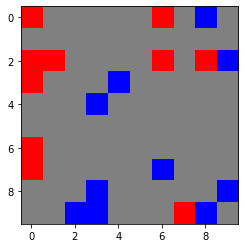

In [4]:
#1b
def print_grid(grid):
    n = len(grid)
    cmap = colors.ListedColormap(['blue', 'gray','red']) #choosing colors to plot
    bounds = [-n,-0.5,0.5,n] #defining the bounds for the colors

    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap, norm=norm)


    plt.show()

print_grid(my_first_grid)


Because electrostatic forces are inversely proprtional to the square of the distance $ F= \frac{q _{1}\cdot q _{2}}{4\cdot \pi \cdot \varepsilon \cdot \varepsilon _{0}\cdot r^{2}} $
 we make the assumption that only neighbors attract each other. This means that we want a function that finds the neighbour coordinates of a given coordinate.  




1c) The following is the solution to task 1c. This is the function mentioned above. It takes a grid and 2 coordinates as input, and returns the 4 nearest neighbors of the given coordinates (taking edge conditions into consideration). the coordinates are returned as an array of arrays. This function will be useful later, especially when it comes to cluster formations.

In [5]:
@jit(nopython=True)
#function that returns the neighbor of a coordinate
def nearest_neighbors(grid,x_0,y_0):
    n = len(grid)
    x = y_0
    y = x_0
    
    

    
    #defining the neighboring indexes
    down = np.array([y-1,x])
    up = np.array([y+1,x])
    left = np.array([y,x-1])
    right = np.array([y,x+1])
    
    #taking care of the edge conditions
    
    if x == 0:
        left = np.array([y,n-1])
    if x == n-1:
        right = np.array([y,0])
    if y == 0:
        down = np.array([n-1,x])
    if y == n-1:  
        up = np.array([0,x])
        
    
    boundary_array =[right,up,left,down]
                      
    return(boundary_array)

 

1d) This function calculates the energy of a monomer system. It takes the grid as input and returns the energy as a float. It iterates through the grid twice. First it calculates the energy of all horizontal neighbors, then it calculates the energy of all vertical neighbors. This is the function that will be used to calculate the energy in the MC method.

In [6]:
@jit(nopython=True)
def grid_energy(grid):
    
    n = len(grid)

    #defining constants
    a = 23.0E-6
    e0 = 8.85E-12
    e = 1.6E-19
    Alpha = ((e)**2)/(4*np.pi*(a**2)*78*e0)

    E_y = 0 
    E_x = 0 
    
    for array in grid: # iterating over the grid to find horisontal neighbors
        for i in range(n):
            x = array[i]*array[(i+1) % n] #product of neighbors, the % takes care of the edge conditions
            if x != 0:
                energyPack = x/(abs(x)) #this adds 1 or -1 to E depending on the the sign of x
                E_x = E_x + energyPack # adding the energy
    
    #likewise but for vertical neighbors    
    for i in range(n):
        for l in range(n):
            x = grid[i][l]*grid[(i+1) % n][l]
            if x != 0:
                energyPack = x/(abs(x))
                E_y = E_y+energyPack
                
    E = Alpha*(E_y +E_x) # adding the energys together, and multiplying by alpha to get the right value

    return E

my_first_grid_energy = grid_energy(my_first_grid)
print(my_first_grid_energy)


1.6736236744082335e-20


1e) This is the function to move monomers that will be used in the MC method for monomers. It is mostly taken from the code 'getting started' notebook given on the subject website. It takes the value of the monomer thats about to be moved, the grid, and direction (random integer from 0 to 3) as input. It returns the grid after the move has been made. The function chooses a random neighbor using the nearest_neighbor function and implements the move if the given neighbor is not occupied.

In [7]:
@jit(nopython=True)

#code for moving monomers thats used in the montecarlo simulation
#the method taken from the getting startes notebook thats provided
def move_monomer(grid, monomer_value, direction):
    grid0 = grid.copy() #copying the grid
    monomer_coordinates = np.argwhere(grid==monomer_value)[0] #finding coordinates of given monomer
    
    neighbors = nearest_neighbors(grid0, monomer_coordinates[0],monomer_coordinates[1]) #finding neighbors of the point
    selected_neighbor = neighbors[direction] #selecting random neighbor
    if grid0[selected_neighbor[0], selected_neighbor[1]] == 0:  #checking if the gridpoint is occupied
        grid0[selected_neighbor[0], selected_neighbor[1]] = monomer_value # and assigning the new value if it is not
        grid0[monomer_coordinates[0], monomer_coordinates[1]] = 0   
    return(grid0)



1e) Now we have the tools to implement the MC method for monomer systems. Since we know the rules that dictate the monomer system, we can simulate it as a markov chain and measure its physical properties. The Montecarlo method that is used here is called the Metropolis algorithm. As input it takes a randomly generated grid, number of steps, and temperature. It returns the grid after #steps iterations, as well a list with the energy of the system at every step. The function is based on the pseudo code in algorithm 2. For each step a random monomer is selected, and the move_monomer function is applied to it. The move is applied if the resulting grid has a lower energy than than the previous. The move is also carried through if thermal fluctuation condition goes through. ie if the random decimal between 0 and 1 is less than $e^{-B (E_new - E_old)}$. The energy is also added to a list for each step.



Runtime:  1.569 s
portion of energy diff steps:  2.118 %  portion of heat steps:  58.914 %
Runtime:  0.665 s
portion of energy diff steps:  12.514 %  portion of heat steps:  61.642 %


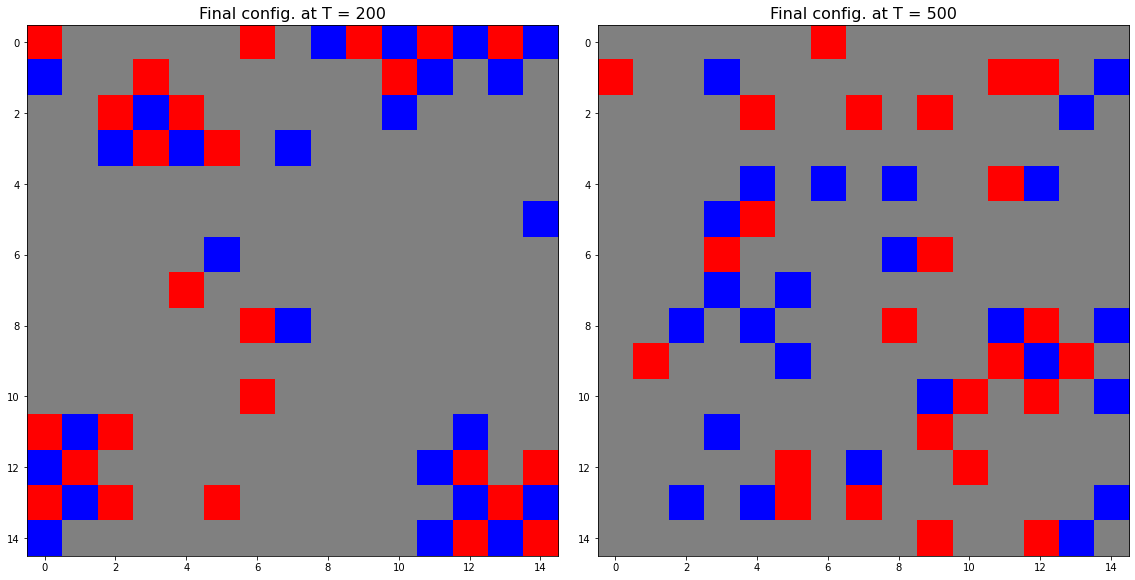

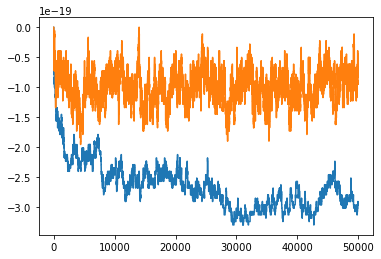

In [8]:
#@jit(nopython=True)

def montecarlo (grid, steps, T):
    start=time()

    #assigning constants
    kB = 1.38E-23
    B = 1/(kB*T)
    
    E_list = []  #list that will be filled by energy values

    num_heat_trans = 0 #these numbers will tell how many times the two types of monomer moves occur
    num_e_diff = 0
    
    num_monomers = len(np.argwhere(grid))
    max_value = int(num_monomers/2) #finding the given m of the monomer
    
    for i in range(steps): #the MC simulation
        
        newgrid = grid.copy() #copying the grid
        
        abs_monomer = rdm.randint(1,max_value)
        monomer_value = abs_monomer* (rdm.randint(0,1)-0.5)*2 #this finds the value of a random monomer in the grid
        
        direction = rdm.randint(0,3) #get a random int to give a random direction to the monomer
        
        newgrid = move_monomer(grid, monomer_value, direction) #the grid after the move
        #energies before and after move
        E_n = grid_energy(newgrid) 
        E = grid_energy(grid)
        
        if E_n < E: # checking if the new grid has lower energy, and allowing the move if it is,
                num_e_diff += 1 #counting the move
                
                grid = newgrid.copy() 

                
                E_list.append(E_n) #storing the energy in the list

        
                
        elif rdm.random() < np.exp(-B*(E_n-E)): #checking if the thermal fluctuation move is triggered
                num_heat_trans += 1 #counting the move
                grid = newgrid.copy() #realizing the move
                E_list.append(E_n) #storing the energy in the list
        else:
                E_list.append(E) #counting the move
        
    stop=time()  
    print ("Runtime: ", round(stop-start,3), "s")  
    print("portion of energy diff steps: ", 100* num_e_diff/steps,"%  portion of heat steps: ", 100*num_heat_trans/steps, "%")
    return grid, E_list


#We generate and plot the grids that are requested in 1f).

grid_init = generate_grid_of_monomers(15,25)

grid_200,E_list_200 = montecarlo(grid_init,50000,200)



grid_500,E_list_500 = montecarlo(grid_init,50000,500)

np.savez('grid200500.npz',T200 = grid_200, T500 = grid_500) #we save the grids so we can plot it later in 1g)

data = np.load('grid200500.npz')
#print (data['T200'])


def plot_adjacent2(grid1,grid2): #function that plots the grids next to each other. recycled code

    n = len(grid2)
    fig, axs = plt.subplots(1, 2 ,figsize = (16,8))

    cmap = colors.ListedColormap(['blue', 'gray','red']) #choosing colors to plot
    bounds = [-n,-0.5,0.5,n] #defining the bounds for the colors
    norm = colors.BoundaryNorm(bounds, cmap.N)
 

    axs[0].imshow(grid1, cmap=cmap, norm=norm)
    axs[1].imshow(grid2, cmap=cmap, norm=norm)

    axs[0].title.set_text('Final config. at T = 200')
    axs[0].title.set_size(16)
    axs[1].title.set_text('Final config. at T = 500')
    axs[1].title.set_size(16)    
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()


    plt.show()


plot_adjacent2(grid_200,grid_500)

x_list = np.linspace(0,len(E_list_200)-1,len(E_list_200))

plt.plot(x_list,E_list_200)
plt.plot(x_list, E_list_500)
plt.show()

Above we see the grids and energyplots for the MC method after 50000 steps

   1e) To visually determine the number of steps needed before the systems reach equilibrium we look at when the energy
   stops decreasing and fluctuates around some value. In this case it appears to happens almost immediately for the 
   500 degree case. After less than 1000 steps. And after around 10000 steps for the 200 degree case.
   We note that it happens much quicker in the high temperature case. To explain this we can consider the fact that
   that the start energy is closer to the equilibrium energy of the 500 degree simulation. But with how quickly 
   the temperature drops we can assume that this doesnt have too big of an impact.


   Local energy minima is a more impactful consideration. If the simulation reaches a local energy minima,
   (or a configuration with very few possible moves that decrease energy), it will need to trigger the thermal condition
   that allows a monomer to move even if it doesnt decrease energy. This probabaility is higher at higher temperatures so
   the second simulation will more quickly get out of minimas, while the low temperature simulation will have a tendency
   to get 'stuck' at minimas. Accordingly, it takes longer for the low temperature simulation to reach its equilibrium

In [9]:

def plotte_poly2(grid,title): #function for plotting polymers
    fig, ax = plt.subplots()
    M = np.amax(grid)
    min_val, max_val = -M, M
    plt.title(title)
    ax.matshow(grid)#, cmap=plt.cm.Blues)


1g) We know look at cluster formations in the monomers grid. 

Here is the function that return the cluster grid of a given grid (as well as the number of clusters). Cluster_iteration iterates over the grid, and when it hits a monomer it calls the recursive function cluster_recursion. Cluster recursion takes in the grid, the coordinates, and the integer that is assigned to the cluster. It uses the nearest_neighbor function to find the monomer neighbors of the given monomer. It then calls itself on the coordinates of the neighbors it finds. Cluster_recursion changes the value of the monomers find to the cluster id, which ensures that the same monomer coordinates wont be called by the function again. The function keeps going until there are no unchanged monomers in the cluster. 

Then the cluster_iteration function keeps iterating over the grid and does the same to the rest of the clusters, with the cluster id increasing by one for each cluster. Meaning the monomers of the first cluster have value 1, the second 2 and so on.

In [10]:
@jit(nopython=True)
def cluster_recursion(grid, x, y,cluster_id):


    
    naboer = nearest_neighbors(grid,x,y) #finding neighbors of point
    grid[x,y] = cluster_id

    for elem in naboer: 
        x1, y1 = elem[0],elem[1] #neighbor coordinates
        if grid[x1, y1] != 0: #checking if the given neighbor is a monomer
            if grid[x1,y1] != cluster_id: #checking that the neighbor hasnt already been visited
                grid[x1,y1] = cluster_id  #giving the monomer the integer of the particular cluster
                cluster_recursion(grid, x1, y1,cluster_id) #calling the function again on the neighbor that was found
                

    return grid
    
@jit(nopython=True)
def cluster_iteration(grid): #function that runs the recursion
    grid1 = np.copy(grid)
    cluster_id = 0
    n = len(grid1) 
    newgrid = np.copy(grid1)
    for i in range(n):
        for l in range(n): 
            if grid1[i,l] != 0:
                grid1[i,l] = -10
    for i in range(n):
        for l in range(n): 
            if grid1[i,l] == -10:
                cluster_id += 1
                cluster_recursion(grid1, i, l, cluster_id)
                
                

    return grid1, cluster_id





1f) Here we use the cluster function to plot the cluster grid of the monomer grid we found in 1f)

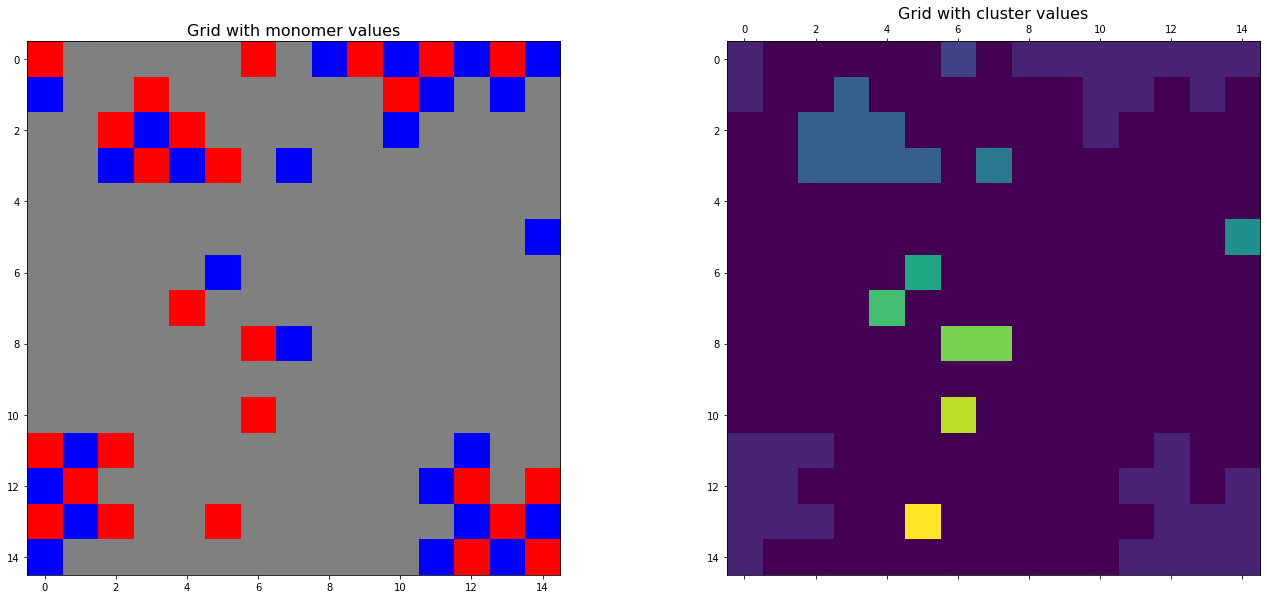

In [11]:
#plotting the cluster grid of the monomer grid we used in 1f)

def plot_adjacent(grid1,grid2):

    #The rest of the code is taken from the polymer plot function and the monomer plot function

    fig, axs = plt.subplots(1,2,figsize = (20,8)) #create adjacent subplots

    n = len(grid2)

    cmap = colors.ListedColormap(['blue', 'gray','red']) #choosing colors to plot
    bounds = [-n,-0.5,0.5,n] #defining the bounds for the colors

    norm = colors.BoundaryNorm(bounds, cmap.N)
    #fig2, ax2 = plt.subplots()

    axs[0].imshow(grid2, cmap=cmap, norm=norm)

    plt.subplots_adjust(top=0.85)
    plt.tight_layout()

    axs[0].title.set_text('Grid with monomer values')
    axs[0].title.set_size(16)
    axs[1].title.set_text('Grid with cluster values')
    axs[1].title.set_size(16)


    M = np.amax(grid1) 
    min_val, max_val = -M, M
    axs[1].matshow(grid1)
    
   


    plt.show()
    
grid_1f = data['T200']
grid_1f_copy = np.copy(grid_1f)
cluster_grid_1f,num_clusters = cluster_iteration(grid_1f)

#print(cluster_iteration(copy_)[0])
plot_adjacent(cluster_grid_1f,grid_1f_copy)

We have now implemented enough functions to do a large scale simulation. We want to calculate the expected value <d> of the cluster size for 10 evenly spaced temperature between 100 and 1000. <d> can be calculated by taking the number of monomers and dividing it by the number of clusters. As stated in the introduction do we use the mean value as an approximation for the expected value. We take the average over 30 <d> values for each temperature. Becuse of the Central limit theorem the approximation will tend towards a normal distribution, where the average is an unbiased estimator.
    
As described in the task we take our first measurement after t_equil steps, then take a measurement every thousand steps after that. The run time is still low (< 30 seconds) so we a use higher t_equil, t_max = 150000 instead of 100000. This helps ensure that we reach equilibrium by the time we start measurements. We take 30 measurements, n = 30. 

We run the simulation twice to see how 'd' varies for different randomly generated start grids.

The following functions prepare the simulation.
calc_T_equil calculates t_equil for a given temperature. 
montecarlo2 implements the neccesary changes to the original montecarlo method. It now also returns a list of the grids we are interested in measuring

In [12]:
#1h
#@jit(nopython=True)

#function that calculates the equilibrium time of a given temperature
def calc_T_equal(T):
    tmax=150000
    s=1/200
    tlow=100
    c=10000
    return int(tmax*np.exp(-s*(T-tlow))+c)

#@jit(nopython=True)

#this is the monte carlo method used for 1h. 
#it is the same as before except it returns a list of the 10 grids where we are supposed to measure the grid size
#
def montecarlo2(grid, steps, T):
    
    
    kB = 1.38E-23
    B = 1/(kB*T)
    d_list = 0
    grid_list = []  #create the grid list
    num_heat_trans = 0
    
    num_e_diff = 0
    
    num_monomers = len(np.argwhere(grid))
    
    m = int(num_monomers/2)
    
    for i in range(steps):
        
        newgrid = grid.copy()
        
        
        abs_monomer = rdm.randint(1,m)
        monomer_value = abs_monomer* (rdm.randint(0,1)-0.5)*2
        
        direction = rdm.randint(0,3)
        
        newgrid = move_monomer(grid, monomer_value, direction)
        
        E_n = grid_energy(newgrid)
        E = grid_energy(grid)
        
        if i > calc_T_equal(T) :
            if i % 1000 == 0:
                grid_list.append(grid) #append the grids at the given steps
        
        if E_n < E:
            num_e_diff += 1 
            grid = newgrid.copy()
                
        elif rdm.random() < np.exp(-B*(E_n-E)):
                num_heat_trans += 1
                grid = newgrid.copy()
    return grid, grid_list

grid_e = generate_grid_of_monomers(15,25)


1h) large_sim_montecarlo executes the large scale montecarlo function. It runs the simulation for evenly spaced temperatures from 100 to 1000

runtime: 10.116533041000366


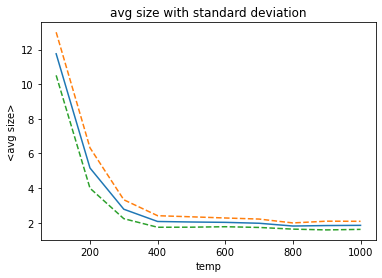

runtime: 11.228641986846924


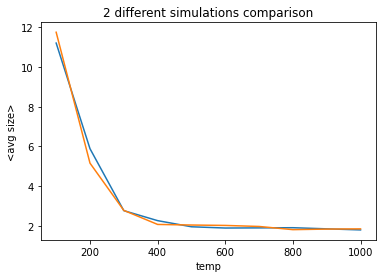

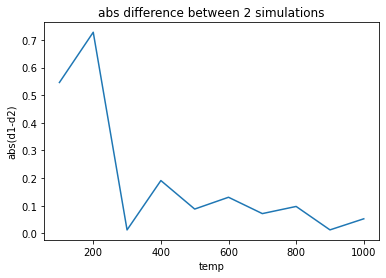

In [13]:

#@jit(nopython=True)
def large_sim_montecarlo (N, M):
    start_time = time()
    size_list=[] #list we will add the avg cluster sizes to
    std_list = [] #list we will add the stds to
    for T in range(100,1100,100): #iterating over the temperatures 100, 200, ..1000
        
        rand_grid = generate_grid_of_monomers(N,M) #initial grid
        sum_=0 #we use this to get sum of the size measurements
        cluster_size_list = [] # we use this list and np.std to calculate the standard deviation
        grid,grid_liste = montecarlo2(rand_grid, calc_T_equal(T)+30000 , T) 

        #we get grid_liste which is the list of the grids that we want to take measurements of
        #meaning with 1000 steps in between and after t_equil

        for element in grid_liste:
            num_clusters = cluster_iteration(element)[1] #cluster_recursion gives the number of clusters in the grids we want to measure
            cluster_size_list.append(2*M/num_clusters)
            sum_ += 2*M/num_clusters #this gives us the average cluster size from the number of clusters 

        stdev = np.std(cluster_size_list)                   
        size_avg = sum_/len(grid_liste) #this gets us the average

        size_list.append(size_avg) #we add the average for this temperature to the list of averages
        std_list.append(stdev)

    run_time = time() - start_time
    print('runtime:',run_time)
        
    return size_list,std_list
        
    
#plotting the avg size and temperature against each other
T_list1=np.linspace(100,1000,10)
d_list1,std_list1=large_sim_montecarlo (15, 25)
plt.plot(T_list1,d_list1)
plt.ylabel("<avg size>")
plt.xlabel("temp")


list_std1 = []
for i in range(len(d_list1)):
    list_std1.append(d_list1[i]+std_list1[i])

list_std2 = []
for i in range(len(d_list1)):
    list_std2.append(d_list1[i]-std_list1[i])

plt.plot(T_list1,list_std1,'--')
plt.plot(T_list1,list_std2,'--')
plt.title('avg size with standard deviation')

plt.show()


T_list2=np.linspace(100,1000,10)
d_list2,std_list2=large_sim_montecarlo (15, 25)
plt.plot(T_list2,d_list2)
plt.plot(T_list1,d_list1)

plt.ylabel("<avg size>")
plt.xlabel("temp")
plt.title('2 different simulations comparison')

plt.show()

difference=[]
for i in range (len(d_list2)):
    difference.append(abs(d_list2[i]-d_list1[i]))


plt.plot(T_list1,difference)
plt.ylabel("abs(d1-d2)")
plt.xlabel("temp")
plt.title('abs difference between 2 simulations')
plt.show()
plt.show()

As we see from the plot d decreases with higher temperatur. Meaning that higher temperatures incentivise smaller clusters

We have that $\beta = \frac{1}{k_{B}T}$ decrases with higher temperatur.
Which means that  $ exp(-\beta(E_{new}-E) )$  increase, and the possibility of a movement due to the temperatur is higher.
This means that eventough a cluster with many monomers and low energy is formed the chance of a monomer leaving this cluster is higher.

The average cluster size deviate more for lower temperatures. This is because at lower temperature the start grid is more significant. A monomer is less likely to move away from a low energy cluster, therefor the cluster that are randomly made in the start grid has a big effect on the movement of the monomers.

# Polymers

We have until this point only discussed the movements of seperate monomers, and how they form clusters. 
Further in the simulations we will focus on monomers moving together as polymers. Polymer are bigger structures than monomers, and are later in this task able to change shape. These features make the numerical methods required more complex.

In our simulation we will only consider polymers that can not split up. This means that movements that cause the polymer to break are deemed non valid.

We start with generating a random grid with 2*M polymers of size L in 2a).

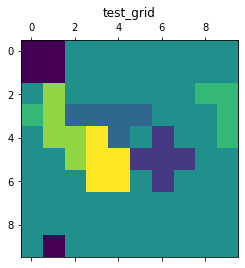

In [14]:
@jit(nopython=True)

def generate_grid_of_polymers(n,m,L):
    grid = np.zeros((n,n),dtype=np.dtype('i2')) # oppretter griden
    
    # fills the grid with values from -m to m
    for i in range(m):
        while True:
            polym_list=[] #list of monomerens in polymer
            x_rand = rdm.randint(0,n-1) #creating random coordinates
            y_rand = rdm.randint(0,n-1) 
            if grid[x_rand,y_rand] == 0:
                grid[x_rand,y_rand] = i+1 
                polym_list.append([x_rand,y_rand])
                
                num = 0
                while num < (L-1):
                    random_base = polym_list[rdm.randint(0,len(polym_list)-1)] #chosing ran monom from polymer
                    neighb_spaces = nearest_neighbors(grid,random_base[0],random_base[1]) #finding neighb
                    ran_num_added_monomers = rdm.randint(0,3) #adding a random number of monom
                    for j in range (ran_num_added_monomers):
                        if num < (L-1) : 
                            rand_neighb = neighb_spaces[rdm.randint(0,3)] #chosing one neighbour
                            if grid[rand_neighb[0],rand_neighb[1]] == 0 :
                                grid[rand_neighb[0],rand_neighb[1]]= i+1 #assignes the nabour the same value as the base
                                polym_list.append([rand_neighb[0],rand_neighb[1]]) 
                                num +=1
                
                 
                
                        
                break                    
        
        
        
        while True: #again for negative values
            polym_list=[]
            x_rand = rdm.randint(0,n-1)
            y_rand = rdm.randint(0,n-1)
            if grid[x_rand,y_rand] == 0:
                grid[x_rand,y_rand] = -(i+1)
                polym_list.append([x_rand,y_rand])
                
                num = 0
                while num < (L-1):
                    random_base = polym_list[rdm.randint(0,len(polym_list)-1)] #chosing ran monom
                    neighb_spaces = nearest_neighbors(grid,random_base[0],random_base[1])
                    ran_num_added_monomers = rdm.randint(0,3)
                    for j in range (ran_num_added_monomers):
                        if num < (L-1) :
                            rand_neighb = neighb_spaces[rdm.randint(0,3)]
                            if grid[rand_neighb[0],rand_neighb[1]] == 0 :
                                grid[rand_neighb[0],rand_neighb[1]]=-( i+1)
                                polym_list.append([rand_neighb[0],rand_neighb[1]])
                                num +=1
                
                
                
                break
        
        
    return grid





#example

grid_of_pol = generate_grid_of_polymers(10,3,5)
plotte_poly2(grid_of_pol,'test_grid')




There are several ways to define randomly constructing a polymer. Which one we chose will affect the polymer´s structure. Our method is this:
1. A monomer is randomly placed on the grid
2. The monomer is given a random number of randomly placed neighbors
3. A random monomer is chosen from the polymer
4. This monomer is given a random number of neighbors, as long as the size does not exceed L
5. Steps 3 and 4 are repeated until the polymer has size L 


This way of making polymers will favour a more compact, box-like structure. This affects the movement possibilities of the polymer, particularily with rigid_move. A box will have bigger chance of moving inn all directions, than a more snake-like structure.

An important part of the Montecarlo simulation is calculating the energy of the grid. We now modify our energy function from part 1 to work with polymers.

2a) This energy function works somewhat differently to the one in 1d). It now uses np.argwhere to find the coordinates of all the monomers in the grid, then it uses nearest_neighbor on each one. Lastly it calculates the energy of all monomer pairs belonging to different polymers.

In [15]:
#2b
@jit(nopython=True)
def grid_energy_poly(grid):
    
    n = len(grid)
    
    E = 0
    a = 91E-6
    e0 = 8.85E-12
    e = 1.6E-19
    Alpha = ((e)**2)/(4*np.pi*(a**2)*78*e0)
    
    indexes = np.argwhere(grid) #Find coord for monomers. (non zero values)
    
    #print(indexes)
    
    for element in indexes: #each element is a monomer
        x = element[0] #finding coord.
        y = element[1]
        neighbors = nearest_neighbors(grid,x,y)
        for nabo in neighbors:
            x2 = nabo[0] #finding neighbour coord.
            y2 = nabo[1]
            
            test = grid[x,y]*grid[x2,y2] #calculating energy
            if test != 0:
                if grid[x,y] != grid[x2,y2]: #applying energy if neighbour is a nonzero and not in the same polymer.
                    E += test/abs(test)
    
    E = E*Alpha*0.5 #We divide by 2 because each pair is counted twice
    
    
    return E






We now need a function for moving the polymers. The polymers can move in several ways. We will start with the simplest form of movement. A rigid move where the entire polymer moves in the same direction. If any part of the polymer is blocked the polymer will not move.

Numpy has a function called np.roll that we will need later. However, jit doesnt allow you to call np.roll on 2d arrays, so we implemented the function ourselves. The function moves all nonzero elements in an array in a given direction, and will be useful in the movement functions

In [16]:
@jit(nopython=True)
def nproll (grid,back_forw,  down_right): 
    
    
    n = len(grid)
    newgrid = grid.copy() 
    
    if back_forw == 1:
        if down_right == 1:
            for i in range(n): 
                for l in range(n):
                    newgrid[i,l] = grid[i,(l+1) % n]
    
    if back_forw == -1:
        if down_right == 1:
            for i in range(n): 
                for l in range(n):
                    newgrid[i,l] = grid[i,(l-1) %n]
                    
                    
    if back_forw == 1:
        if down_right == 0:
            for i in range(n): 
                for l in range(n):
                    newgrid[i,l] = grid[(i-1)%n ,l]
                    
    if back_forw == -1:
        if down_right == 0:
            for i in range(n): 
                for l in range(n):
                    newgrid[i,l] = grid[(i+1)%n ,l]
                    
                    
    return newgrid
        

2c) 
We can now construct the function that employs rigid polymer movement. It works like this:

1: We have three grids, the original grid, one grid where the polymer we want to move is set to zero. And one grid where all other polymers is set to zero.

2: We use our roll function to move the polymer in the third grid. 

3: We iterate through the second and third grid and check for monomers that overlap. 

4: If there is no overlap we  moved grid = second + third grid
   If there is overlap we return the original grid

In [17]:
#2c
@jit(nopython=True)




def move_polymer(grid,m,direct): #direction : 0,1,2,3 = down, right, up, left
    new_grid=np.copy(grid) #copying grid
    indexes = np.argwhere (grid) #Finding all monomers with value
    #direct == 0: #down
    zero_grid = np.copy(new_grid) #copying grid
    for x in range (len(zero_grid[0])):
        for y in range (len(zero_grid[0])):
            if zero_grid[x,y] != m:
                zero_grid[x,y]=0 #making a grid where only the chosen polum has value
                    
                    
    new_grid=new_grid-zero_grid #setting chosen polym value = 0 in old grid
    if direct == 0:
        zero_grid = nproll(zero_grid,1,0) #shifting all nonzero values one down.
        
    elif direct == 1:
        zero_grid = nproll(zero_grid,1,1) #shifting right
        
    elif direct == 2:
        zero_grid = nproll(zero_grid,-1,0) #shifting up
        
    elif direct == 3:
        zero_grid = nproll(zero_grid,-1,1) #shifting left
        
    else:
        print ("not valid direction")
        return grid
    
    for x in range (len(zero_grid[0])):
        for y in range (len(zero_grid[0])):
                
            if (zero_grid[x,y] != 0 and new_grid [x,y]!=0): #checking if polym overlap
                #print ("Illegal move")
                return grid
                
                    
                
    new_grid = zero_grid + new_grid 
    return new_grid
              



2d) We now implement alghorithm 2 with polymer systems and rigid movement. The method is the same as in 1e),  but now with different movement and energy functions. We also plot the grid and energy for the given parameters.

Time used:  9.88 s
Amount of random movements due to heat:  79.93 %
Time used:  6.99 s
Amount of random movements due to heat:  87.06 %


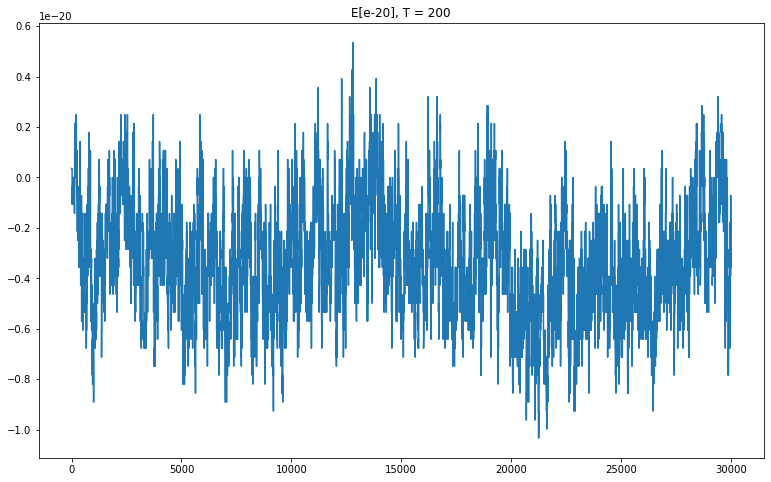

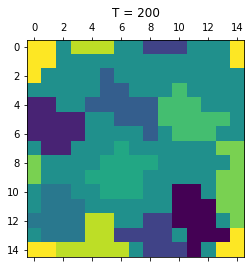

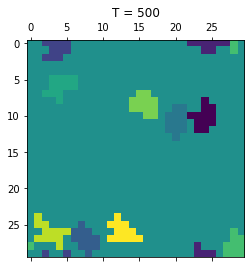

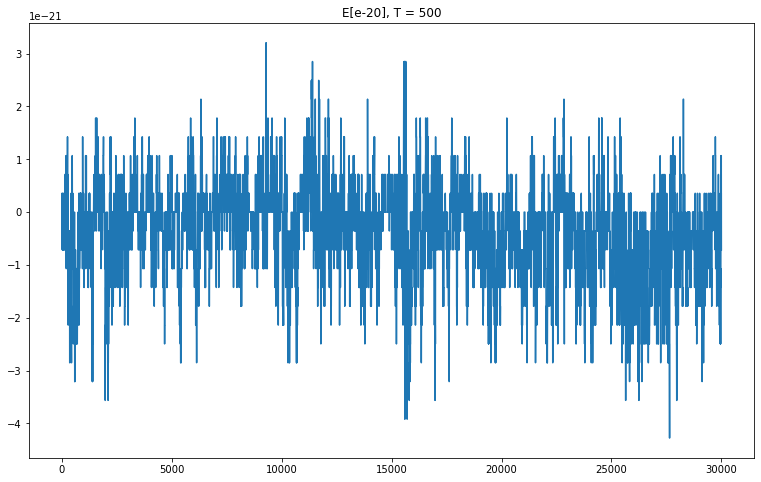

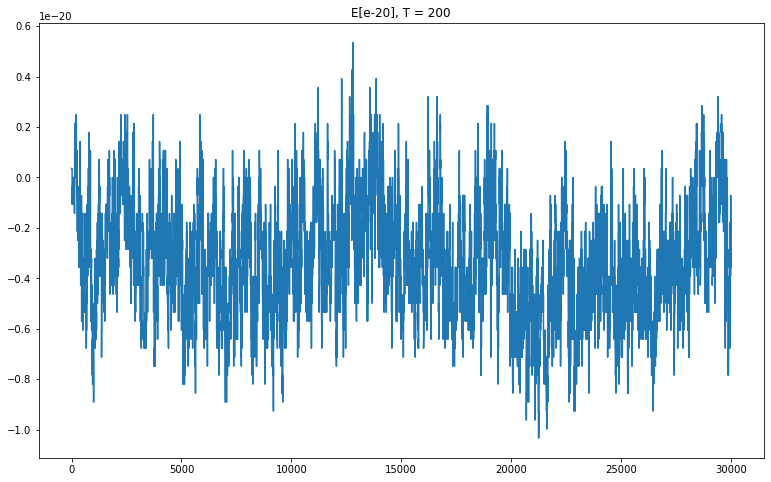

In [18]:
# 2d
#@jit(nopython=True)
import time 




def montecarlo_poly (grid, N, M, T): 
    start_time = time.time()
    kB = 1.38E-23
    B = 1/(kB*T)
    E_initial = grid_energy_poly(grid)
    E_list = np.zeros(N) #List of energies for tracking
    E_list[0]=E_initial
    random_movement_count = 0
    for i in range (N):
        E = grid_energy_poly(grid) #Calculate energy
        random_polymer = rdm.randint(-M,M) 
        while random_polymer == 0:
            random_polymer = rdm.randint(-M,M) #Chosing random polymer   
        random_direction = rdm.randint(0,3) #Chosing random direction
        
        test_grid = move_polymer(grid,random_polymer,random_direction) #moving
        rand_float = rdm.uniform(0,1) #generate random number between 0,1
        
    
        new_grid = np.copy(test_grid) #
        E_new = grid_energy_poly(new_grid)
        #print (E_new-E)
        if E_new < E :
            grid = new_grid.copy()
            E_list[i] = E_new
                
        elif rand_float < np.exp(-B*(E_new-E)):
            grid = new_grid.copy()
            E_list[i] = E_new
            random_movement_count += 1
                
        else:
            E_list[i] = E
    stop_time=time.time()
    print ("Time used: ", round((stop_time-start_time),2), "s")
    print("Amount of random movements due to heat: ", round(random_movement_count/N*100,2), "%")
    return grid,E_list

grid_of_poly2d = generate_grid_of_polymers(15,5,12)

            
MC_grid2d, Energy2d = montecarlo_poly (grid_of_poly2d, 30000, 5, 200)

plotte_poly2(MC_grid2d, 'T = 200')

#Plotting energy

X_list2d=np.arange(0,len(Energy2d))

plt.figure(figsize = (13,8))
plt.plot(X_list2d,Energy2d)
plt.title('E[e-20], T = 200')

plt.figure(1)





grid_of_poly2d = generate_grid_of_polymers(30,5,12)

            
MC_grid2d, Energy2d = montecarlo_poly (grid_of_poly2d, 30000, 5, 200)

plotte_poly2(MC_grid2d,'T = 500')

#Plotting energy

X_list2d=np.arange(0,len(Energy2d))

plt.figure(figsize = (13,8))
plt.plot(X_list2d,Energy2d)
plt.title('E[e-20], T = 500')
plt.figure(2)






In the first simulation with N=15 we see that the grid is very crowded. There will not be many possibilities for the polymers to move. But when they move there is a bigger chance for them to hit another polymer. Therefore the amount of movements due to heat is lower. 

For N=30 there is a lot of space for the polymers to move, and the chance of them hitting another polymer is lower. So they move mostly due to randomness. We note that the energy very clearly fluctuates around 0. This is because when no polymers have neighbors the energy clearly is 0.

We see that the monomer MonteCarlo function used about 1s, while the polymer used a bit over 7s. The energy calculating functions similarly, so it is the movement functions that have the greatest impact on the time differences. This makes sense, as a monover move only requires us to check if a single square is occupied. Whereas a polymer move needs to check every tile the polymer moves to. We also have to iterate over the grid to find the coordinates of every element in the monomer.

2e) 
To make our simulations more realistic we improve the polymer movement function, by implementing a function for medium flexibility movement. The polymers will now be able to change their shape to enable more movement, by only causing the rows/columns that are blocked to not move.   

This way of defining movement makes it possible for a polymer to break  apart, because of this we also implement a function to check if the polymer is broken. And if it is, the move is canceled.

In [19]:

@jit(nopython=True)
def medium_flex_move_cluster(grid,m,direct): #direction : 0,1,2,3 = up, left, down, right
    number_of_pol = np.amax(grid) * 3
    L=0
    
    if direct == 0: #up
        new_grid = np.copy(grid) 
        transposed_new_grid = new_grid.transpose() #transpose for easier iteration
        for x in range(len(grid[0])):
            for y in range(len(grid[0])):
                if transposed_new_grid[x,y]==m: #finding all monomer with m value                   
                    transposed_new_grid[x,y]=m+x+2*number_of_pol #assigning each row a new value
                    
    
            transposed_new_grid=move_polymer(transposed_new_grid,m+x+2*number_of_pol,1) #tries to move row rigid
            moved_monom=np.argwhere(transposed_new_grid==m+x+2*number_of_pol) #finding all monomers with changed value
            for i in range (len(moved_monom)):
                #print(transposed_new_grid[i])
                if transposed_new_grid[moved_monom[i][0],moved_monom[i][1]] == m+x+2*number_of_pol:
                    transposed_new_grid[moved_monom[i][0],moved_monom[i][1]] += (-2*number_of_pol - x) #changing value back
        new_grid = transposed_new_grid.transpose() #transpose back
        
        
        #same logic for all directions
    elif direct == 1: #left
        new_grid = np.copy(grid)
        for x in range(len(grid[0])):
            for y in range(len(grid[0])):
                if new_grid[x,y]==m:                    
                    new_grid[x,y]=m+x+2*number_of_pol
                    
    
            new_grid=move_polymer(new_grid,m+x+2*number_of_pol,1)
            moved_monom=np.argwhere(new_grid==m+x+2*number_of_pol)
            for i in range (len(moved_monom)):
                if new_grid[moved_monom[i][0],moved_monom[i][1]] == m+x+2*number_of_pol:
                    new_grid[moved_monom[i][0],moved_monom[i][1]] += (-2*number_of_pol - x)
        
        
        
    
    elif direct == 2: #down
        new_grid = np.copy(grid)
        transposed_new_grid = new_grid.transpose() #For ned, beveg mot høyre
        for x in range(len(grid[0])):
            for y in range(len(grid[0])):
                if transposed_new_grid[x,y]==m:                    
                    transposed_new_grid[x,y]=m+x+2*number_of_pol
                    
    
            transposed_new_grid=move_polymer(transposed_new_grid,m+x+2*number_of_pol,3)
            moved_monom=np.argwhere(transposed_new_grid==m+x+2*number_of_pol)
            for i in range (len(moved_monom)):
                #print(transposed_new_grid[i])
                if transposed_new_grid[moved_monom[i][0],moved_monom[i][1]] == m+x+2*number_of_pol:
                    transposed_new_grid[moved_monom[i][0],moved_monom[i][1]] += (-2*number_of_pol - x)
        new_grid = transposed_new_grid.transpose()
        
        
    
    elif direct == 3: #right
        new_grid = np.copy(grid)
        for x in range(len(grid[0])):
            for y in range(len(grid[0])):
                if new_grid[x,y]==m:                    
                    new_grid[x,y]=m+x+2*number_of_pol
                    
    
            new_grid=move_polymer(new_grid,m+x+2*number_of_pol,3)
            moved_monom=np.argwhere(new_grid==m+x+2*number_of_pol)
            for i in range (len(moved_monom)):
                if new_grid[moved_monom[i][0],moved_monom[i][1]] == m+x+2*number_of_pol:
                    new_grid[moved_monom[i][0],moved_monom[i][1]] += (-2*number_of_pol - x)
        
    
    
    
    
    
    
    
    cluster_grid = np.copy(new_grid)
    
    
    for x in range (len(cluster_grid)):
        for y in range (len(cluster_grid)):
            if cluster_grid[x,y] != m :
                cluster_grid[x,y] = 0
                
                
            else:
                L+=1
                x0=x
                y0=y
                cluster_grid[x,y]+=2*number_of_pol + x*10 + y
    

    if cluster_iteration(cluster_grid)[1] > 1:
        #print("not valid")
        return grid
        
            

    
    
        
        
    return new_grid

Steps in medium flex move:

1. If we want to move up or down we transpose the grid. 

2. We iterate through the grid and assign every monomer in the chosen polymer a new value.

3. The value we give them is 3 times M + x, this way every polymer in the same row will have the same value. This is also why we transposed the grid.

4. We use rigid move on each row separately.

5. To check if the polymer is broken we make a new grid with all others polymers set to zero. We then use cluster_iteration to find the number of clusters in this grid before and after the move. If #clusters > 1 we know that the polymer is broken

6. If the polymer is not broken we return the new grid.

Now we can implement the montecarlo method with flexible polymer movement:

In [20]:

@jit(nopython=True)
def montecarlo_poly_flex2 (grid, N, M, T,t_equil):        
    kB = 1.38E-23
    B = 1/(kB*T)
    E_initial = grid_energy_poly(grid)
    E_list = np.zeros(N) #List of energies for tracking
    E_list[0]=E_initial
    #h=1
    grid_list=[]
    for i in range (N): 
       
        E = grid_energy_poly(grid) #Calculate energy
        random_polymer = rdm.randint(-M,M) 
        while random_polymer == 0:
            random_polymer = rdm.randint(-M,M) #Chosing random polymer   
        random_direction = rdm.randint(0,3) #Chosing random direction
        
        test_grid = medium_flex_move_cluster(grid,random_polymer,random_direction) #moving
        rand_float = rdm.uniform(0,1) #generate random number between 0,1
        
        if i > t_equil :
            if i % 1000 == 0:
                grid_list.append(grid)
                
        new_grid = np.copy(test_grid) #
        E_new = grid_energy_poly(new_grid)
        #print (E_new-E)
        if E_new < E :
            grid = new_grid.copy()
            E_list[i] = E_new
                
        elif rand_float < np.exp(-B*(E_new-E)):
            grid = new_grid.copy()
            E_list[i] = E_new
                
        else:
            E_list[i] = E
    
    return grid,E_list, grid_list




2h) The montecarlo function above includes the neccessary features to make the measurements we want in this task. The method is the same as in 1h) when it comes to obtaining the measurements.  To complete the task we create two functions: 

mean_cluster_size takes T, M, N, and L as inputs. It generates a random grid of polymers and employs the flex montecarlo method which returns the list of grids that we want to measure. It then calculates the average number of #clusters in the grids, as well as &lt;d&gt;/L. . The function returns both these values, as well the number of measured grids.

mean_cluster_size_with_temp_variation&nbsp;runs&nbsp;mean_cluster_size&nbsp;at&nbsp;13&nbsp;evenly&nbsp;spaced&nbsp;temperatures&nbsp;from&nbsp;3 to 39. It adds the values it recieves from mean_cluster_size to lists which are then printed and plotted in a separate function

3
6
9
12
15
18
21
24
27
30
33
36
39
[1.093, 1.181, 1.217, 1.304, 1.657, 1.804, 1.874, 2.218, 3.098, 3.305, 4.524, 5.687, 7.772]
[9.224489795918368, 8.673469387755102, 8.387755102040817, 7.877551020408164, 6.346938775510204, 5.938775510204081, 5.673469387755102, 5.0, 4.142857142857143, 3.693877551020408, 2.795918367346939, 2.2244897959183674, 1.5714285714285714]
reuntime:  579.8010189533234


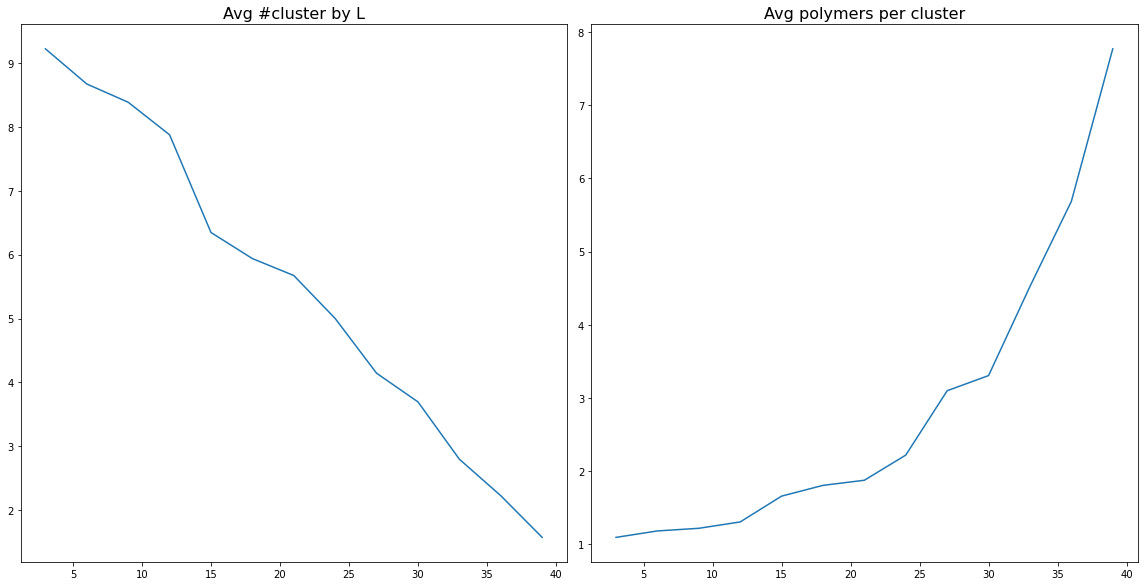

In [21]:

#@jit(nopython=True)
def mean_cluster_size(T,M,N,L):
    poly_grid = generate_grid_of_polymers(N,M,L)
    t_equil = 10000
    t = 1000
    n = 50
    cluster_grid_list = montecarlo_poly_flex2(poly_grid, t_equil+n*t, M, T,t_equil)[2] #Making a list of the grid for eack test
    m_len=len(cluster_grid_list) 
    m_sum=0
    d_L_sum=0
    for i in range(m_len): #iterating over the grids in the list
        grid_copy = np.copy(cluster_grid_list[i])
        m_new = cluster_iteration(grid_copy)[1] #finding the number of clusters in each grid
        m_sum+=m_new #adding numbers of clusters from each test grid to a sum
    
        
        d_L_sum+=2*M/(m_new) #cluster size will be number of polymers 2M divided by number of clusters m
    m_avg = float(m_sum/m_len) #taking the mean value by deviding sum of clusters from all grids by number of grids
    return m_avg, m_len, d_L_sum

    return m_avg, m_len, d_L_sum

def plot_graphs(m_list,d_list):
    L_list=np.linspace(3,39,13)

    fig,axs = plt.subplots(1,2,figsize =(16,8) )
    
    

    axs[0].plot(L_list,m_list)
    axs[1].plot(L_list,d_list)
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()

    axs[0].title.set_text('Avg #cluster by L')
    
    axs[0].title.set_size(16)
    axs[1].title.set_text('Avg polymers per cluster')
  
    axs[1].title.set_size(16)

   


    plt.show()

#data_2h = np.load('lists_2h.npz')
#plot_graphs(data_2h['m_vals'],data_2h['d_vals'])

def mean_cluster_size_with_temp_variation():
    m_list=[]
    d_L_list=[]
    start_time = time.time()

    for L in range(3,40,3):
        m_avg, m_len, d_L_sum = mean_cluster_size(300,5,30,L)
        m_list.append(m_avg)    #taking the mean value by deviding sum of clusters from all grids by number of grids
        d_L_list.append(round(d_L_sum/m_len,3))  #average cluster size will be number of polymers 2M divided by number of clusters m
        print(L) #This simply lets us assess the progress of the function
    print(d_L_list)
    print(m_list)

    runtime = time.time() - start_time
    print('reuntime: ',runtime)

    return(m_list, d_L_list)




m_list2, d_L_list2 = mean_cluster_size_with_temp_variation()
np.savez('lists_2h.npz',m_vals = grid_200, d_vals = grid_500)





plot_graphs(m_list2,d_L_list2)


#Vi bør kanskje vurdere større n og større t_equil her siden koden kjører såpass fort. 
#men samtidig går det ekstremt fort å nå equilibrium for flex move, så er kanskje ikke vits, bedre å få
#flere målinger

These plots live up to our expectations. The average number of clusters decrease as L increases. This makes sense because the polymers are able to reach each other more easily with bigger size. They wont be stranded for instance. The smallest polymers simply might not be able to reach each other. For L = 39 about 43% of the grid is covered, so its obvious that polymers are very likely to touch each other.  

d/L, which is the number of polymers per cluster, naturally also increases as L increases.



Here we have chosen a much lower t_equil than the ones we used in 1h). This is because the polymer systems appear to reach equilibrium much faster than the monomer systems. We observed this when plotting the polymer system energies. This means we can use a much larger n. This gives us more measurements and means that the average we obtain will be a more precise estimate of the expcted value. The runtime is still livable, sitting at around 13 minutes

If you consider the rigid move simulation as opposed to the medium flex, the result would probably be a slightly larger number of clusters. This would be because the polymers will be able to merge more on the surface and form stronger bindings. This will mean that the energy increase when they break apart will be higher, and they are less likely to separate.

The difference in polymer size would also make a difference. For smaller sizes of polymers we think that the start conditions will be of higher impact to the simulation because there is a higher chance that polymers spawn isolated. This variance in the initial grid we believe will cause a higher variance overall.














2h) Qualitative analysis of M.
Lastly we will discuss how changing the system parameter M, number of polymers in the start grid, will affect the formation of clusters.
It is obvious that a higher number of polymers will make it possible to form clusters of bigger sizes. But it is not trivial that this will increase the average size <d> of the clusterers.
    
The reason we consider M to be an interesting is that it isnt obvious whether increasing M will increase d, the average cluster size. Of course, as M grows really big and almost all of the grid becomes occupied, increasing M makes d bigger, but this isnt always the case. 

For instance, if we look at a system 1 that consists of 6 polymers vs a system 2 that consists of 4 polymers. There are several configurations for each system, and either one could have the bigger d. This causes a complex probability distribution for d where d could either increase or decrease as M grows. We know the edges of the distribution. In that 'd' is biggest for large M and smallest for M = 1. It would have been interesting to try and determine 'd' for the values of M in between. It does seem like a qualitative approach to this would be hard to find
    
    


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1472cb45-29a0-4706-b899-13752b3b88df' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>